In [1]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

import pandas as pd
import xgboost, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

import nltk

from textblob import TextBlob

import numpy as np

In [44]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop=stopwords.words('english')

nltk.download('punkt')

from nltk.stem import PorterStemmer

from textblob import Word
nltk.download('wordnet')

nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kacper\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kacper\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Kacper\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Kacper\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [3]:
train=pd.read_csv("Corona_NLP_train.csv",encoding='latin1')
test=pd.read_csv("Corona_NLP_test.csv",encoding='latin1')
train

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


In [4]:
train['word_count']=train['OriginalTweet'].apply(lambda x: len(str(x).split(" ")))
train[['OriginalTweet', 'word_count']].head(10)

,OriginalTweet,word_count
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,8
1,advice Talk to your neighbours family to excha...,38
2,Coronavirus Australia: Woolworths to give elde...,14
3,My food stock is not the only one which is emp...,40
4,"Me, ready to go at supermarket during the #COV...",38
5,As news of the regionÂs first confirmed COVID...,36
6,Cashier at grocery store was sharing his insig...,28
7,Was at the supermarket today. Didn't buy toile...,12
8,Due to COVID-19 our retail store and classroom...,46
9,"For corona prevention,we should stop to buy th...",42


In [5]:
train['char_count']=train['OriginalTweet'].str.len()
train[['OriginalTweet', 'char_count']].head(10)

,OriginalTweet,char_count
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,111
1,advice Talk to your neighbours family to excha...,237
2,Coronavirus Australia: Woolworths to give elde...,131
3,My food stock is not the only one which is emp...,306
4,"Me, ready to go at supermarket during the #COV...",310
5,As news of the regionÂs first confirmed COVID...,250
6,Cashier at grocery store was sharing his insig...,180
7,Was at the supermarket today. Didn't buy toile...,119
8,Due to COVID-19 our retail store and classroom...,280
9,"For corona prevention,we should stop to buy th...",267


In [6]:
def avg_word(sentence):
    words=sentence.split()
    return (sum(len(word) for word in words)/len(words))
train['avg_words'] = train['OriginalTweet'].apply(lambda x:avg_word(x))
train[['OriginalTweet', 'avg_words']].head(10)

,OriginalTweet,avg_words
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,13.000000
1,advice Talk to your neighbours family to excha...,5.263158
2,Coronavirus Australia: Woolworths to give elde...,8.428571
3,My food stock is not the only one which is emp...,6.000000
4,"Me, ready to go at supermarket during the #COV...",6.525000
5,As news of the regionÂs first confirmed COVID...,5.972222
6,Cashier at grocery store was sharing his insig...,5.464286
7,Was at the supermarket today. Didn't buy toile...,7.846154
8,Due to COVID-19 our retail store and classroom...,5.222222
9,"For corona prevention,we should stop to buy th...",5.380952


In [7]:
train['stopwords']=train['OriginalTweet'].apply(lambda x: len([x for x in x.split() if x in stop]))
train[['OriginalTweet', 'stopwords']].head(10)

,OriginalTweet,stopwords
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,2
1,advice Talk to your neighbours family to excha...,11
2,Coronavirus Australia: Woolworths to give elde...,1
3,My food stock is not the only one which is emp...,14
4,"Me, ready to go at supermarket during the #COV...",13
5,As news of the regionÂs first confirmed COVID...,8
6,Cashier at grocery store was sharing his insig...,9
7,Was at the supermarket today. Didn't buy toile...,2
8,Due to COVID-19 our retail store and classroom...,18
9,"For corona prevention,we should stop to buy th...",16


In [8]:
specialPatt=r"[^a-zA-Z0-9 ]"
train['special_characters']=train['OriginalTweet'].str.findall(specialPatt)
train['special_characters']=train['special_characters'].apply(lambda x: len(x))
train[['OriginalTweet', 'special_characters']].head(10)

,OriginalTweet,special_characters
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,19
1,advice Talk to your neighbours family to excha...,0
2,Coronavirus Australia: Woolworths to give elde...,8
3,My food stock is not the only one which is emp...,37
4,"Me, ready to go at supermarket during the #COV...",35
5,As news of the regionÂs first confirmed COVID...,15
6,Cashier at grocery store was sharing his insig...,12
7,Was at the supermarket today. Didn't buy toile...,18
8,Due to COVID-19 our retail store and classroom...,12
9,"For corona prevention,we should stop to buy th...",8


In [9]:
train['numerics'] = train['OriginalTweet'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
train[['OriginalTweet', 'numerics']].head(10)

,OriginalTweet,numerics
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0
1,advice Talk to your neighbours family to excha...,0
2,Coronavirus Australia: Woolworths to give elde...,0
3,My food stock is not the only one which is emp...,0
4,"Me, ready to go at supermarket during the #COV...",0
5,As news of the regionÂs first confirmed COVID...,0
6,Cashier at grocery store was sharing his insig...,0
7,Was at the supermarket today. Didn't buy toile...,0
8,Due to COVID-19 our retail store and classroom...,0
9,"For corona prevention,we should stop to buy th...",0


In [10]:
train['upper_count'] = train['OriginalTweet'].apply(lambda x: len([x for x in x.split() if x.isupper]))
train[['OriginalTweet', 'upper_count']].head(10)

,OriginalTweet,upper_count
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,8
1,advice Talk to your neighbours family to excha...,38
2,Coronavirus Australia: Woolworths to give elde...,14
3,My food stock is not the only one which is emp...,42
4,"Me, ready to go at supermarket during the #COV...",40
5,As news of the regionÂs first confirmed COVID...,36
6,Cashier at grocery store was sharing his insig...,28
7,Was at the supermarket today. Didn't buy toile...,13
8,Due to COVID-19 our retail store and classroom...,45
9,"For corona prevention,we should stop to buy th...",42


In [11]:
train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))
train['OriginalTweet'].head(10)

0    @menyrbie @phil_gahan @chrisitv https://t.co/i...
1    advice talk to your neighbours family to excha...
2    coronavirus australia: woolworths to give elde...
3    my food stock is not the only one which is emp...
4    me, ready to go at supermarket during the #cov...
5    as news of the regionâs first confirmed covid...
6    cashier at grocery store was sharing his insig...
7    was at the supermarket today. didn't buy toile...
8    due to covid-19 our retail store and classroom...
9    for corona prevention,we should stop to buy th...
Name: OriginalTweet, dtype: object

In [12]:
train['OriginalTweet'] = train['OriginalTweet'].str.replace(r"(\.|\,|!|\?|:|;)", '')
train['OriginalTweet'].head(10)

0    @menyrbie @phil_gahan @chrisitv https//tco/ifz...
1    advice talk to your neighbours family to excha...
2    coronavirus australia woolworths to give elder...
3    my food stock is not the only one which is emp...
4    me ready to go at supermarket during the #covi...
5    as news of the regionâs first confirmed covid...
6    cashier at grocery store was sharing his insig...
7    was at the supermarket today didn't buy toilet...
8    due to covid-19 our retail store and classroom...
9    for corona preventionwe should stop to buy thi...
Name: OriginalTweet, dtype: object

In [13]:
train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
train['OriginalTweet'].head(10)

0    @menyrbie @phil_gahan @chrisitv https//tco/ifz...
1    advice talk neighbours family exchange phone n...
2    coronavirus australia woolworths give elderly ...
3    food stock one empty please panic enough food ...
4    ready go supermarket #covid19 outbreak i'm par...
5    news regionâs first confirmed covid-19 case c...
6    cashier grocery store sharing insights #covid_...
7    supermarket today buy toilet paper #rebel #toi...
8    due covid-19 retail store classroom atlanta op...
9    corona preventionwe stop buy things cash use o...
Name: OriginalTweet, dtype: object

In [14]:
freq=pd.Series(' '.join(train['OriginalTweet']).split()).value_counts()[:10]
freq

#coronavirus    15816
prices           7728
covid-19         7235
food             6698
store            6688
supermarket      6557
grocery          6023
#covid19         5613
people           5436
consumer         4214
dtype: int64

In [15]:
freq=list(freq.index)
train['OriginalTweet']= train['OriginalTweet'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
train['OriginalTweet'].head(10)

0    @menyrbie @phil_gahan @chrisitv https//tco/ifz...
1    advice talk neighbours family exchange phone n...
2    coronavirus australia woolworths give elderly ...
3    stock one empty please panic enough everyone t...
4    ready go outbreak i'm paranoid stock litteraly...
5    news regionâs first confirmed case came sulli...
6    cashier sharing insights #covid_19 prove credi...
7    today buy toilet paper #rebel #toiletpapercris...
8    due retail classroom atlanta open walk-in busi...
9    corona preventionwe stop buy things cash use o...
Name: OriginalTweet, dtype: object

In [16]:
leastFreq=pd.Series(' '.join(train['OriginalTweet']).split()).value_counts()[-10:]
leastFreq

complication             1
@nbcnightlynews          1
pub/restaurant/          1
https//tco/k0kgjgjjxu    1
boosts)                  1
@thedatadump             1
dowjones                 1
https//tco/0kpufqwvqn    1
affordably               1
https//tco/4wlx2t3geb    1
dtype: int64

In [17]:
leastFreq= list(leastFreq.index)
train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x: " ".join(x for x in x.split() if x not in leastFreq))
train['OriginalTweet'].head(10)

0    @menyrbie @phil_gahan @chrisitv https//tco/ifz...
1    advice talk neighbours family exchange phone n...
2    coronavirus australia woolworths give elderly ...
3    stock one empty please panic enough everyone t...
4    ready go outbreak i'm paranoid stock litteraly...
5    news regionâs first confirmed case came sulli...
6    cashier sharing insights #covid_19 prove credi...
7    today buy toilet paper #rebel #toiletpapercris...
8    due retail classroom atlanta open walk-in busi...
9    corona preventionwe stop buy things cash use o...
Name: OriginalTweet, dtype: object

In [18]:
train['OriginalTweet'][:5].apply(lambda x: str(TextBlob(x).correct()))
#ZMIENIĆ NA WSZYSTKIE

0    @menyrbie @phil_gahan @christ http//to/ifz9fan...
1    advice talk neighbours family exchange phone n...
2    coronavirus australia woolworths give elderly ...
3    stock one empty please panic enough everyone t...
4    ready go outbreak i'm paranoid stock literary ...
Name: OriginalTweet, dtype: object

In [19]:
TextBlob(train['OriginalTweet'][1]).words
#ZMIENIĆ NA WSZYSTKIE

WordList(['advice', 'talk', 'neighbours', 'family', 'exchange', 'phone', 'numbers', 'create', 'contact', 'list', 'phone', 'numbers', 'neighbours', 'schools', 'employer', 'chemist', 'gp', 'set', 'online', 'shopping', 'accounts', 'poss', 'adequate', 'supplies', 'regular', 'meds', 'order'])

In [20]:
# st = PorterStemmer()
# train['OriginalTweet'][:5].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
# #ZMIENIĆ NA WSZYSTKIE

In [21]:
train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
train['OriginalTweet'].head(10)

0    @menyrbie @phil_gahan @chrisitv https//tco/ifz...
1    advice talk neighbour family exchange phone nu...
2    coronavirus australia woolworth give elderly d...
3    stock one empty please panic enough everyone t...
4    ready go outbreak i'm paranoid stock litteraly...
5    news regionâs first confirmed case came sulli...
6    cashier sharing insight #covid_19 prove credib...
7    today buy toilet paper #rebel #toiletpapercris...
8    due retail classroom atlanta open walk-in busi...
9    corona preventionwe stop buy thing cash use on...
Name: OriginalTweet, dtype: object

In [22]:
TextBlob(train['OriginalTweet'][1]).ngrams(2)
#zmienić na wszystkie

[WordList(['advice', 'talk']),
 WordList(['talk', 'neighbour']),
 WordList(['neighbour', 'family']),
 WordList(['family', 'exchange']),
 WordList(['exchange', 'phone']),
 WordList(['phone', 'number']),
 WordList(['number', 'create']),
 WordList(['create', 'contact']),
 WordList(['contact', 'list']),
 WordList(['list', 'phone']),
 WordList(['phone', 'number']),
 WordList(['number', 'neighbour']),
 WordList(['neighbour', 'school']),
 WordList(['school', 'employer']),
 WordList(['employer', 'chemist']),
 WordList(['chemist', 'gp']),
 WordList(['gp', 'set']),
 WordList(['set', 'online']),
 WordList(['online', 'shopping']),
 WordList(['shopping', 'account']),
 WordList(['account', 'po']),
 WordList(['po', 'adequate']),
 WordList(['adequate', 'supply']),
 WordList(['supply', 'regular']),
 WordList(['regular', 'med']),
 WordList(['med', 'order'])]

In [23]:
tf1 = (train['OriginalTweet'][1:2]).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
tf1.columns = ['words','tf']
tf1

,words,tf
0,neighbour,2
1,number,2
2,phone,2
3,account,1
4,list,1
5,set,1
6,gp,1
7,med,1
8,advice,1
9,create,1


In [24]:
for i,word in enumerate(tf1['words']):
  tf1.loc[i, 'idf'] = np.log(train.shape[0]/(len(train[train['OriginalTweet'].str.contains(word)])))
tf1

,words,tf,idf
0,neighbour,2,6.060801
1,number,2,4.656442
2,phone,2,5.076073
3,account,1,5.568903
4,list,1,3.846364
5,set,1,4.052867
6,gp,1,4.811019
7,med,1,2.933036
8,advice,1,4.997528
9,create,1,5.012021


In [25]:
tf1['tfidf'] = tf1['tf'] * tf1['idf']
tf1

,words,tf,idf,tfidf
0,neighbour,2,6.060801,12.121602
1,number,2,4.656442,9.312883
2,phone,2,5.076073,10.152146
3,account,1,5.568903,5.568903
4,list,1,3.846364,3.846364
5,set,1,4.052867,4.052867
6,gp,1,4.811019,4.811019
7,med,1,2.933036,2.933036
8,advice,1,4.997528,4.997528
9,create,1,5.012021,5.012021


In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
 stop_words= 'english',ngram_range=(1,1))
train_vect = tfidf.fit_transform(train['OriginalTweet'])

train_vect

<41157x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 394485 stored elements in Compressed Sparse Row format>

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1,1),analyzer = "word")
train_bow = bow.fit_transform(train['OriginalTweet'])
train_bow

<41157x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 439485 stored elements in Compressed Sparse Row format>

In [28]:
train['sentiment'] = train['OriginalTweet'].apply(lambda x: TextBlob(x).sentiment[0])
train[['OriginalTweet', 'sentiment']].head()

,OriginalTweet,sentiment
0,@menyrbie @phil_gahan @chrisitv https//tco/ifz...,0.000000
1,advice talk neighbour family exchange phone nu...,0.166667
2,coronavirus australia woolworth give elderly d...,-0.200000
3,stock one empty please panic enough everyone t...,0.175000
4,ready go outbreak i'm paranoid stock litteraly...,-0.077778


# wektoryzacja

In [29]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = 'glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

(400000, 100)

In [30]:
from gensim.models import KeyedVectors # load the Stanford GloVe model
filename = 'glove.6B.100d.txt.word2vec'
model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [31]:
tweets=np.array(train['OriginalTweet'])
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(tweets)

vectorizer.get_feature_names()

['00',
 '000',
 '0000',
 '0000009375',
 '000042',
 '0000hrs',
 '000162',
 '0006',
 '000francs',
 '000s',
 '001',
 '0010',
 '0016',
 '0017â',
 '0025450557',
 '0026691661',
 '005',
 '00541296',
 '009p',
 '00am',
 '00ctnbm22s',
 '00f7gzyfom',
 '00pdsup4wb',
 '00pm',
 '00pwksjyey',
 '00pxujzhmf',
 '00ry5yh8ro',
 '00urjfxstc',
 '00zyjjmcet',
 '01',
 '010',
 '0100am',
 '0101',
 '0103641972',
 '0113',
 '0115',
 '012020',
 '0121',
 '01236',
 '01273',
 '0131',
 '01392576476',
 '014',
 '01449',
 '0147',
 '01474',
 '01625',
 '0169061211',
 '017569',
 '01756986',
 '0175698634',
 '01765',
 '01892',
 '01952',
 '01ae5shygg',
 '01he1moz2x',
 '01hr',
 '01kg',
 '01laovtqn2',
 '01oc3pig5b',
 '01wbjdrnfd',
 '02',
 '020',
 '0200hrs',
 '0203',
 '02037386000',
 '0207pm',
 '021',
 '0214996028',
 '02268443322',
 '023',
 '024p',
 '025',
 '0258',
 '027',
 '0274',
 '028',
 '02890391225',
 '029',
 '02920',
 '02ch7r0rlu',
 '02ddkwsnxo',
 '02dlx6wbt3',
 '02kklx47ez',
 '02uqpatpn5',
 '02utqkozdg',
 '02zy7g1xsx',
 '03

In [33]:
model['go']

array([-0.078894,  0.4616  ,  0.57779 , -0.71637 , -0.13121 ,  0.4186  ,
       -0.29156 ,  0.52006 ,  0.089986, -0.35062 ,  0.51755 ,  0.51998 ,
        0.15218 ,  0.41485 , -0.12377 , -0.37222 ,  0.0273  ,  0.75673 ,
       -0.8739  ,  0.58935 ,  0.46662 ,  0.62918 ,  0.092603, -0.012868,
       -0.015169,  0.25567 , -0.43025 , -0.77668 ,  0.71449 , -0.3834  ,
       -0.69638 ,  0.23522 ,  0.11396 ,  0.02778 ,  0.071357,  0.87409 ,
       -0.1281  ,  0.063576,  0.067867, -0.50181 , -0.28523 , -0.072536,
       -0.50738 , -0.6914  , -0.53579 , -0.11361 , -0.38234 , -0.12414 ,
        0.011214, -1.1622  ,  0.037057, -0.18495 ,  0.01416 ,  0.87193 ,
       -0.097309, -2.3565  , -0.14554 ,  0.28275 ,  2.0053  ,  0.23439 ,
       -0.38298 ,  0.69539 , -0.44916 , -0.094157,  0.90527 ,  0.65764 ,
        0.27628 ,  0.30688 , -0.57781 , -0.22987 , -0.083043, -0.57236 ,
       -0.299   , -0.81112 ,  0.039752, -0.05681 , -0.48879 , -0.18091 ,
       -0.28152 , -0.20559 ,  0.4932  , -0.033999, 

# koniec wektoryzacji

# Dane treningowe i testowe

In [106]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(train['OriginalTweet'], train['Sentiment'])
# train_x, train_y= model_selection.train_test_split(train['OriginalTweet'])
# test_x, test_y=model_selection.train_test_split(test['OriginalTweet'])

encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)
train_y.shape, train_x.shape

((30867,), (30867,))

# Liczba wystąpień słowa w tekście

In [107]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(train['OriginalTweet'])

xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)
print(xtrain_count)

  (0, 557)	1
  (0, 8425)	1
  (0, 10176)	1
  (0, 11453)	1
  (0, 20792)	1
  (0, 23158)	1
  (0, 23409)	1
  (0, 24404)	1
  (0, 26833)	1
  (0, 30867)	1
  (0, 33138)	1
  (0, 36002)	1
  (0, 38733)	1
  (0, 38765)	1
  (0, 47659)	1
  (0, 55208)	1
  (0, 58624)	1
  (0, 62863)	1
  (0, 63719)	1
  (0, 65962)	1
  (0, 67696)	1
  (0, 68473)	1
  (0, 75226)	1
  (0, 75514)	1
  (0, 76588)	1
  :	:
  (30865, 68845)	1
  (30865, 69034)	1
  (30865, 70797)	1
  (30865, 71696)	1
  (30865, 71853)	1
  (30865, 74091)	1
  (30866, 18243)	1
  (30866, 20385)	1
  (30866, 34644)	1
  (30866, 41833)	1
  (30866, 53078)	1
  (30866, 54297)	2
  (30866, 57389)	1
  (30866, 57390)	1
  (30866, 62092)	1
  (30866, 62219)	1
  (30866, 65024)	1
  (30866, 66640)	1
  (30866, 68221)	1
  (30866, 68273)	1
  (30866, 69931)	1
  (30866, 75226)	1
  (30866, 76638)	1
  (30866, 78775)	1
  (30866, 80248)	1


# Częstotliwość faz i odwrócona częstotliwość faz

In [108]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(train['OriginalTweet'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(train['OriginalTweet'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(train['OriginalTweet'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x) 

D:\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:501: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [109]:
embeddings_index = {}
for i, line in enumerate(open('wiki-news-300d-1M.vec', encoding="utf-8")):
    values = line.split()
    embeddings_index[values[0]] = numpy.asarray(values[1:], dtype='float32')

token = text.Tokenizer()
token.fit_on_texts(train['OriginalTweet'])
word_index = token.word_index

train_seq_x = sequence.pad_sequences(token.texts_to_sequences(train_x), maxlen=70)
valid_seq_x = sequence.pad_sequences(token.texts_to_sequences(valid_x), maxlen=70)

embedding_matrix = numpy.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# NLP features - liczba słów, liter, znaków intterpunkcyjnych, słów z wielkimi literami, zaczynąjących się od wielkiej litery i średnia długiść słów

In [110]:
train['char_count'] = train['OriginalTweet'].apply(len)
train['word_count'] = train['OriginalTweet'].apply(lambda x: len(x.split()))
train['word_density'] = train['char_count'] / (train['word_count']+1)
train['punctuation_count'] = train['OriginalTweet'].apply(
    lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
train['title_word_count'] = train['OriginalTweet'].apply(
    lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
train['upper_case_word_count'] = train['OriginalTweet'].apply(
    lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

# Liczba rzeczowników, czasowników, przymiotników, przysłówków i zaimków

In [111]:
pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adjective' :  ['JJ','JJR','JJS'],
    'adverb' : ['RB','RBR','RBS','WRB'],
    'pronoun' : ['PRP','PRP$','WP','WP$']
}

def check_pos_tag(x, flag):
    cnt = 0
    try:
        wiki = textblob.TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt

train['noun_count'] = train['OriginalTweet'].apply(lambda x: check_pos_tag(x, 'noun'))
train['verb_count'] = train['OriginalTweet'].apply(lambda x: check_pos_tag(x, 'verb'))
train['adjective_count'] = train['OriginalTweet'].apply(lambda x: check_pos_tag(x, 'adjective'))
train['adverb_count'] = train['OriginalTweet'].apply(lambda x: check_pos_tag(x, 'adverb'))
train['pronoun_count'] = train['OriginalTweet'].apply(lambda x: check_pos_tag(x, 'pronoun'))

In [112]:
train

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,word_count,char_count,avg_words,stopwords,...,title_word_count,upper_case_word_count,noun_count,verb_count,adj_count,adv_count,pron_count,adjective_count,adverb_count,pronoun_count
0,3799,48751,London,16-03-2020,@menyrbie @phil_gahan @chrisitv https//tco/ifz...,Neutral,6,97,13.000000,2,...,0,0,8,0,1,0,0,1,0,0
1,3800,48752,UK,16-03-2020,advice talk neighbour family exchange phone nu...,Positive,27,185,5.263158,11,...,0,0,17,4,4,0,0,4,0,0
2,3801,48753,Vagabonds,16-03-2020,coronavirus australia woolworth give elderly d...,Positive,12,113,8.428571,1,...,0,0,4,5,2,0,0,2,0,0
3,3802,48754,NaN,16-03-2020,stock one empty please panic enough everyone t...,Positive,19,171,6.000000,14,...,0,0,7,2,8,1,0,8,1,0
4,3803,48755,NaN,16-03-2020,ready go outbreak i'm paranoid stock litteraly...,Extremely Negative,19,176,6.525000,13,...,0,0,11,2,6,1,0,6,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,airline pilot offering stock shelf #nz lockdow...,Neutral,9,79,7.583333,2,...,0,0,5,1,2,1,0,2,1,0
41153,44952,89904,NaN,14-04-2020,response complaint provided citing related del...,Extremely Negative,13,87,5.043478,6,...,0,0,7,3,2,1,0,2,1,0
41154,44953,89905,NaN,14-04-2020,know itâs getting tough @kameronwilds rationi...,Positive,13,102,6.555556,2,...,0,0,9,3,2,0,0,2,0,0
41155,44954,89906,NaN,14-04-2020,wrong smell hand sanitizer starting turn,Neutral,6,40,4.944444,7,...,0,0,4,1,1,0,0,1,0,0


# Modelowanie abstrakcyjnych tematów

In [113]:
lda_model = decomposition.LatentDirichletAllocation(n_components=20, learning_method='online', max_iter=20)
X_topics = lda_model.fit_transform(xtrain_count)
topic_word = lda_model.components_ 
vocab = count_vect.get_feature_names()

n_top_words = 10
topic_summaries = []
for i, topic_dist in enumerate(topic_word):
    topic_words = numpy.array(vocab)[numpy.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
print(topic_summaries)

['hand sanitizer toilet paper tco https toiletpaper alcohol they bottle', 'good first community increase 2020 drop demand said rise result', 'amp 19 worker covid time u home help work s', '2 working much 1 delivery 4 enough part week car', 'government back got care lot positive stayhomesavelives selling man trip', 'grocery went retailer wash something sell key stoppanicbuying cashier closing', 'call coronacrisis coronaviruspandemic coming nothing covid_19 police stophoarding running coronavirusupdate', 'line roll front try following understand president different hey behind', 'canâ old email year imagine stress morning la disgusting building', 'economy socialdistancing food never fall 7 tell aisle staying shut', 'i staff t hour country m public donâ close want', '19 covid life really bank fight demand help test meet', 'tco https oil demand pandemic global u uk market due', 'news across behavior impact change latest brand govt 8 changing', 'state price amazon crisis response ever system

# Modelowanie uczenia maszynowego

## Medoda sprawdzająca dokładność modelu

In [114]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    classifier.fit(feature_vector_train, label)
    
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, valid_y)

## Tablica dokładności

In [133]:
accuracyArray = []
len(accuracyArray)

0

## Naiwny klasyfikator Bayesowski

In [134]:
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xvalid_count)
accuracy = round(accuracy, 3)
print ("NB, Count Vectors: ", accuracy)
accuracyArray.append(accuracy)

accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
accuracy = round(accuracy, 3)
print ("NB, WordLevel TF-IDF: ", accuracy)
accuracyArray.append(accuracy)

accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
accuracy = round(accuracy, 3)
print ("NB, N-Gram Vectors: ", accuracy)
accuracyArray.append(accuracy)

accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
accuracy = round(accuracy, 3)
print ("NB, CharLevel Vectors: ", accuracy)
accuracyArray.append(accuracy)

NB, Count Vectors:  0.453
NB, WordLevel TF-IDF:  0.457
NB, N-Gram Vectors:  0.359
NB, CharLevel Vectors:  0.384


## Klasyfikator liniowy

In [136]:
accuracy = train_model(linear_model.LogisticRegression(), xtrain_count, train_y, xvalid_count)
accuracy = round(accuracy, 3)
print ("LR, Count Vectors: ", accuracy)
accuracyArray.append(accuracy)

accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)
accuracy = round(accuracy, 3)
print ("LR, WordLevel TF-IDF: ", accuracy)
accuracyArray.append(accuracy)

accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
accuracy = round(accuracy, 3)
print ("LR, N-Gram Vectors: ", accuracy)
accuracyArray.append(accuracy)

accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
accuracy = round(accuracy, 3)
print ("LR, CharLevel Vectors: ", accuracy)
accuracyArray.append(accuracy)

D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR, Count Vectors:  0.599


D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR, WordLevel TF-IDF:  0.571


D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR, N-Gram Vectors:  0.365
LR, CharLevel Vectors:  0.497


D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Klasyfikator Support Vector Machine

In [138]:
accuracy = train_model(svm.SVC(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
accuracy = round(accuracy, 3)
print ("SVM, N-Gram Vectors: ", accuracy)
accuracyArray.append(accuracy)

SVM, N-Gram Vectors:  0.369


## Klasyfikator Random Forrest, modele agregujące

In [140]:
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_count, train_y, xvalid_count)
accuracy = round(accuracy, 3)
print ("RF, Count Vectors: ", accuracy)
accuracyArray.append(accuracy)

accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y, xvalid_tfidf)
accuracy = round(accuracy, 3)
print ("RF, WordLevel TF-IDF: ", accuracy)
accuracyArray.append(accuracy)

RF, Count Vectors:  0.544
RF, WordLevel TF-IDF:  0.547


## Klasyfikator Extreme Boosting

In [142]:
accuracy = train_model(xgboost.XGBClassifier(), xtrain_count.tocsc(), train_y, xvalid_count.tocsc())
accuracy = round(accuracy, 3)
print ("Xgb, Count Vectors: ", accuracy)
accuracyArray.append(accuracy)

accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf.tocsc(), train_y, xvalid_tfidf.tocsc())
accuracy = round(accuracy, 3)
print ("Xgb, WordLevel TF-IDF: ", accuracy)
accuracyArray.append(accuracy)

accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf_ngram_chars.tocsc(), train_y, xvalid_tfidf_ngram_chars.tocsc())
accuracy = round(accuracy, 3)
print ("Xgb, CharLevel Vectors: ", accuracy)
accuracyArray.append(accuracy)

D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:52:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Xgb, Count Vectors:  0.578
[22:52:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Xgb, WordLevel TF-IDF:  0.543
[22:53:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Xgb, CharL

## Płytkie sieci neuronowe

In [144]:
def create_model_architecture(input_size):
    input_layer = layers.Input((input_size, ), sparse=True)

    hidden_layer = layers.Dense(100, activation="relu")(input_layer)

    output_layer = layers.Dense(1, activation="sigmoid")(hidden_layer)

    classifier = models.Model(inputs = input_layer, outputs = output_layer)
    classifier.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    return classifier 

classifier = create_model_architecture(xtrain_tfidf_ngram.shape[1])
accuracy = train_model(classifier, xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, is_neural_net=True)
accuracy = round(accuracy, 3)
print ("NN, Ngram Level TF IDF Vectors",  accuracy)
accuracyArray.append(accuracy)

965/965 [==============================] - 2s 2ms/step - loss: -77.6378
NN, Ngram Level TF IDF Vectors 0.136


## Głębokie sieci neuronowe

### Konwulcyjne sieci neuronowe

In [146]:
def create_cnn():
    input_layer = layers.Input((70, ))

    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)

    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_cnn()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
accuracy = round(accuracy, 3)
print ("CNN, Word Embeddings",  accuracy)
accuracyArray.append(accuracy)

965/965 [==============================] - 10s 10ms/step - loss: -72558.9922
CNN, Word Embeddings 0.136


### Long Short Term Model

In [148]:
def create_rnn_lstm():
    input_layer = layers.Input((70, ))

    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    lstm_layer = layers.LSTM(100)(embedding_layer)

    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_rnn_lstm()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
accuracy = round(accuracy, 3)
print ("RNN-LSTM, Word Embeddings",  accuracy)
accuracyArray.append(accuracy)

965/965 [==============================] - 36s 37ms/step - loss: -1880.1561
RNN-LSTM, Word Embeddings 0.136


### Granted Recurrent Unit

In [150]:
def create_rnn_gru():
    input_layer = layers.Input((70, ))

    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    lstm_layer = layers.GRU(100)(embedding_layer)

    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_rnn_gru()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
print ("RNN-GRU, Word Embeddings",  accuracy)
accuracy = round(accuracy, 3)
accuracyArray.append(accuracy)

965/965 [==============================] - 31s 32ms/step - loss: -2785.6592
RNN-GRU, Word Embeddings 0.1357628765792031


### Dwukierunkowe sieci neuronowe

In [152]:
def create_bidirectional_rnn():
    input_layer = layers.Input((70, ))

    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    lstm_layer = layers.Bidirectional(layers.GRU(100))(embedding_layer)

    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_bidirectional_rnn()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
print ("RNN-Bidirectional, Word Embeddings",  accuracy)
accuracy = round(accuracy, 3)
accuracyArray.append(accuracy)

965/965 [==============================] - 37s 38ms/step - loss: -4726.5308
RNN-Bidirectional, Word Embeddings 0.1357628765792031


### Rekurencyjne konwolucyjne sieci neuronowe

In [154]:
def create_rcnn():
    input_layer = layers.Input((70, ))

    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)
    
    rnn_layer = layers.Bidirectional(layers.GRU(50, return_sequences=True))(embedding_layer)
    
    conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)

    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_rcnn()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
print ("RCNN, Word Embeddings",  accuracy)
accuracy = round(accuracy, 3)
accuracyArray.append(accuracy)

965/965 [==============================] - 9s 10ms/step - loss: -88109.3047
RCNN, Word Embeddings 0.1357628765792031


In [155]:
len(accuracyArray)

20

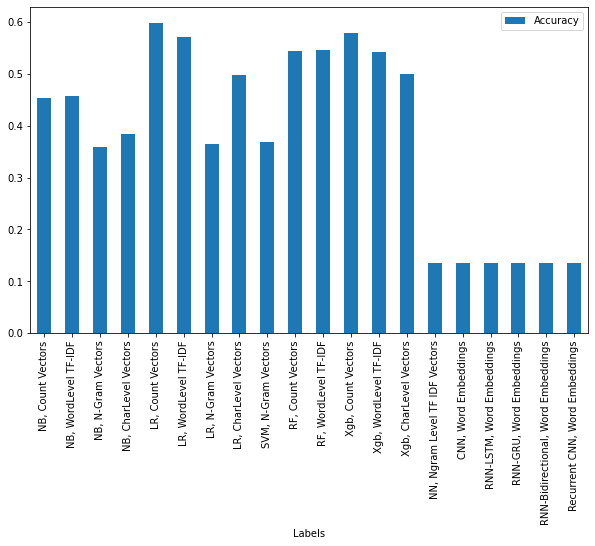

In [156]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))
np.set_printoptions(precision=4, suppress=True)

lbls = ['NB, Count Vectors', 'NB, WordLevel TF-IDF', 'NB, N-Gram Vectors', 'NB, CharLevel Vectors',
            'LR, Count Vectors', 'LR, WordLevel TF-IDF', 'LR, N-Gram Vectors', 'LR, CharLevel Vectors',
             'SVM, N-Gram Vectors',
             'RF, Count Vectors', 'RF, WordLevel TF-IDF',
             'Xgb, Count Vectors', 'Xgb, WordLevel TF-IDF', 'Xgb, CharLevel Vectors',
             'NN, Ngram Level TF IDF Vectors',
             'CNN, Word Embeddings',
             'RNN-LSTM, Word Embeddings', 
             'RNN-GRU, Word Embeddings', 
             'RNN-Bidirectional, Word Embeddings', 
             'Recurrent CNN, Word Embeddings']

lbls = np.array(lbls)
accuracyArray = np.array(accuracyArray)
df = pd.DataFrame({'Accuracy': accuracyArray}, lbls)
df.index.name = 'Labels'
df.plot.bar()

In [157]:
df

,Accuracy
Labels,
"NB, Count Vectors",0.453
"NB, WordLevel TF-IDF",0.457
"NB, N-Gram Vectors",0.359
"NB, CharLevel Vectors",0.384
"LR, Count Vectors",0.599
"LR, WordLevel TF-IDF",0.571
"LR, N-Gram Vectors",0.365
"LR, CharLevel Vectors",0.497
"SVM, N-Gram Vectors",0.369


In [158]:
df[df == df.max()]

,Accuracy
Labels,
"NB, Count Vectors",NaN
"NB, WordLevel TF-IDF",NaN
"NB, N-Gram Vectors",NaN
"NB, CharLevel Vectors",NaN
"LR, Count Vectors",0.599
"LR, WordLevel TF-IDF",NaN
"LR, N-Gram Vectors",NaN
"LR, CharLevel Vectors",NaN
"SVM, N-Gram Vectors",NaN


In [159]:
df[df == df.min()]

,Accuracy
Labels,
"NB, Count Vectors",NaN
"NB, WordLevel TF-IDF",NaN
"NB, N-Gram Vectors",NaN
"NB, CharLevel Vectors",NaN
"LR, Count Vectors",NaN
"LR, WordLevel TF-IDF",NaN
"LR, N-Gram Vectors",NaN
"LR, CharLevel Vectors",NaN
"SVM, N-Gram Vectors",NaN
